In [6]:
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy as sci
import matplotlib.pyplot as plt
import sklearn as skl
import statsmodels.api as sma
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn import decomposition
import statsmodels.stats.multicomp as comp
import seaborn as sns

%matplotlib inline


In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("./data/alola_db.db")
mons = pd.read_sql_query("SELECT * from POKEDEX", con, coerce_float=False)
con.close()
columnLabels = list(mons.columns)

In [ ]:
mons = mons.drop_duplicates("DEXID", )

## Data Processing
1. We need to make a column for average stats for each 'mon
2. We need to label each 'mon by its generation

(We should figure out a way to ignore non-stat changed formes i.e. Arceus, as he may be upsetting the Gen IV data)

In [3]:
mons["AVERAGE_STAT"] = mons["STAT_TOTAL"]/6

gens = pd.Series([0 for i in range(len(mons.index))], index=mons.index)
for ID, mon in mons.iterrows():
    if 0<mon.DEXID<=151:
        gens[ID] = 1
    elif 151<mon.DEXID<=251:
        gens[ID] = 2
    elif 251<mon.DEXID<=386:
        gens[ID] = 3
    elif 386<mon.DEXID<=493:
        gens[ID] = 4
    elif 493<mon.DEXID<=649:
        gens[ID] = 5
    elif 649<mon.DEXID<=721:
        gens[ID] = 6
    elif 721<mon.DEXID<=805:
        gens[ID] = 7
    else:
        gens[ID] = 0

mons["GEN"] = gens

mons.to_csv("./data/pokemon_preUSUM_data.csv")

In [4]:
gen = {}
for i in range(1,8):
    gen[i] = mons[mons.GEN == i]

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


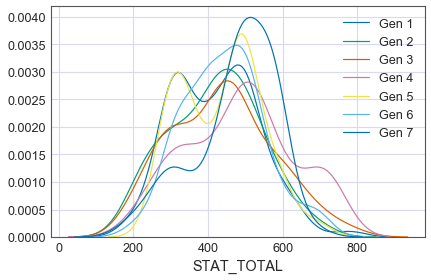

In [7]:
plt.figure(100)
colors = sns.color_palette("colorblind", 7)

for i in range(1,8):
    sns.distplot( mons[mons["GEN"] == i]["STAT_TOTAL"], hist=False,kde=True, color=colors[i-1], label=f"Gen {i}")
plt.legend()
plt.show()

## Some Stats

In [8]:
stat_averages_by_gen = {i:gen[i].AVERAGE_STAT for i in range(1,8)}

testable_data = list(stat_averages_by_gen.values())
data = [list(gen) for gen in testable_data]
data = np.array(data)

In [9]:
averages = {i: stat_averages_by_gen[i].mean() for i in range(1,8)}
averages

{1: 70.11256544502622,
 2: 69.87106918238993,
 3: 72.8844580777096,
 4: 80.97785547785546,
 5: 72.41569767441854,
 6: 73.62179487179492,
 7: 78.73750000000004}

In [10]:
stats.kruskal(*data)

KruskalResult(statistic=36.973964969816784, pvalue=1.7815863055091822e-06)

In [12]:
recarray = mons.to_records()

In [13]:
test = comp.pairwise_tukeyhsd(recarray["AVERAGE_STAT"], recarray["GEN"])

In [14]:
test.summary()

group1,group2,meandiff,lower,upper,reject
1,2,-0.2415,-7.3954,6.9124,False
1,3,2.7719,-3.5264,9.0702,False
1,4,10.8653,4.3337,17.3969,True
1,5,2.3031,-3.9056,8.5119,False
1,6,3.5092,-3.2066,10.225,False
1,7,8.6249,1.7446,15.5052,True
2,3,3.0134,-4.3565,10.3833,False
2,4,11.1068,3.5365,18.6771,True
2,5,2.5446,-4.7489,9.8382,False
2,6,3.7507,-3.979,11.4805,False


## Machine Learning and Clustering

In [15]:
np.random.seed(525_600)

stats_gens = mons[['HP', 'ATTACK', 'DEFENSE',
       'SPECIAL_ATTACK', 'SPECIAL_DEFENSE', 'SPEED', 'GEN']]

X = np.c_[stats_gens]

### PCA

In [16]:
pca = decomposition.PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
pca.explained_variance_

array([ 2527.09553978,   987.58840873,   708.14041093,   497.87845572,
         379.86559948,   234.37349563,     3.89238089])

In [18]:
pca.n_components = 3

In [19]:
X_reduced = pca.fit_transform(X)

In [20]:
X_reduced.shape

(1025, 3)

In [21]:
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 3,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

### K-Means Clustering

In [22]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters = 6)

In [23]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
mons["KMEANS_LABEL"] = pd.Series(k_means.labels_)

In [25]:
plotData = mons[["GEN", "STAT_TOTAL", "KMEANS_LABEL"]]

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


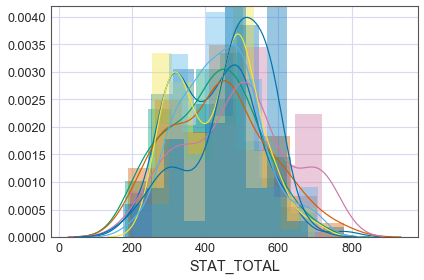

In [31]:
colors = sns.color_palette("colorblind", 7)

for i in range(1,8):
    sns.distplot( plotData[plotData["GEN"] == i]["STAT_TOTAL"], color=colors[i-1])

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


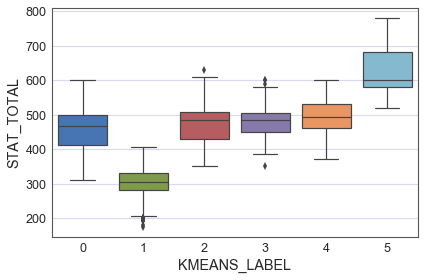

In [32]:
plt.figure(925)
sns.boxplot(x="KMEANS_LABEL", y="STAT_TOTAL", data=plotData)
plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


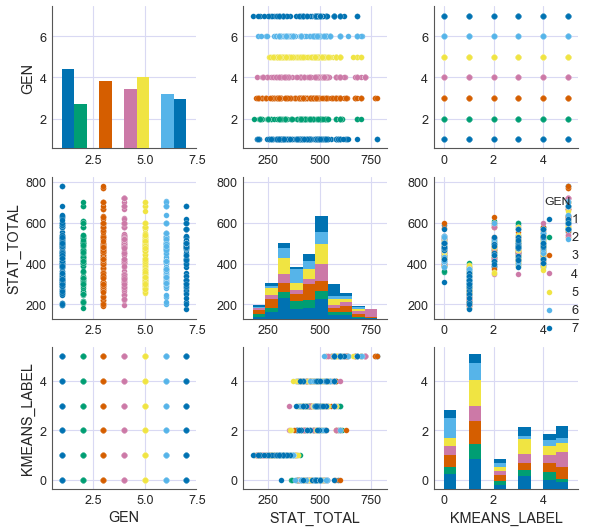

In [28]:
plt.figure(9050624)
sns.pairplot(plotData, kind="scatter", hue="GEN", palette=colors)
plt.show()

In [ ]:
plotData.to_csv("./data/kmeans.csv")